In [1]:
import pandas as pd
import glob
import os
import math
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt

In [2]:
filenames = glob.glob("./temp_data/jet_hyperparameter_run/*/temporal_csv_log.csv")
patience = 5

In [317]:
#these functions load the data into a convenient form
ts,aucs = get_raw_ts_aucs(filenames,patience)
all_t,all_auc,all_maxs = get_global_auc_stats(ts,aucs)
ind = np.argmax(all_maxs)
#cut off redundant parts of the signal for better visuals
all_t = all_t[:ind+1] 
all_maxs = all_maxs[:ind+1]
all_auc = all_auc[:ind+1]

## Statistics of AUC values

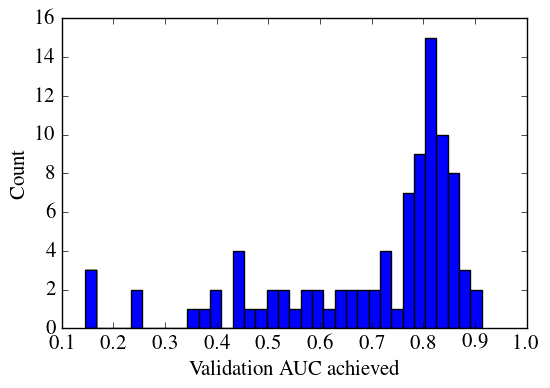

In [549]:
maxs = np.array([np.max(auc) for auc in aucs])
plt.close()
plt.hist(maxs,bins=35,color="b")
# plt.ylim([1e1,1e6])
plt.ylabel('Count',size=fontsize)
plt.xlabel('Validation AUC achieved',size=15)

# plt.xlim([0.8,0.92])
# plt.legend(frameon=False,loc="center left",fontsize=fontsize)
plt.setp(plt.gca().get_yticklabels(),fontsize=fontsize)
plt.setp(plt.gca().get_xticklabels(),fontsize=fontsize)
plt.show()

## Time spent as a function of AUC 

In [522]:
replicas = 1000
num_points = 100000
fontsize = 15
# ind = np.argmax(all_maxs)
# mmp,ttp = place_maxs_onto_grid(all_maxs[:ind+1],all_t[:ind+1],num_points)
mmp,ttp = place_maxs_onto_grid(all_maxs,all_t,num_points,np.unique(np.concatenate(aucs)))
#compute time spent as a function of AUC for many replicas, and place the averaged values onto a grid
# mm,tt = average_accum_curves_by_t(ts,aucs,replicas,num_points)
tt,mm =generate_mean_reach_times(ts,aucs,replicas)


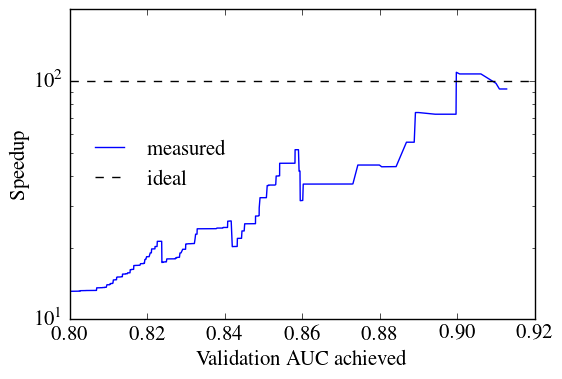

In [535]:
fontsize=15

plt.close()
plt.figure(dpi=300)
plot_ratio = True

if plot_ratio: #plot ratio of curves
    plt.semilogy(mm,tt/ttp,label="measured")
    plt.axhline(100,color="k",linestyle="--",label="ideal")
    plt.ylim([10,200])
    plt.xlabel('Validation AUC achieved',size=15)
    plt.ylabel('Speedup',size=fontsize)
else: #plot both curves
    plt.plot(mmp,ttp,label="parallel")
    plt.semilogy(mm,tt,label="serial")
    plt.semilogy(mm,tt/100,"--g",label="serial, scaled T")
#     plt.plot(all_maxs,all_t)
    plt.ylim([1e1,1e6])
    plt.ylabel('T [seconds]',size=fontsize)
    plt.xlabel('Validation AUC achieved',size=15)

plt.xlim([0.8,0.92])
plt.legend(frameon=False,loc="center left",fontsize=fontsize)
plt.setp(plt.gca().get_yticklabels(),fontsize=fontsize)
plt.setp(plt.gca().get_xticklabels(),fontsize=fontsize)

plt.show()


## AUC as a function of time

In [372]:
replicas = 500
num_points = 10000
#place the running max for the parallel runs onto a grid
ttp,mmp = place_maxs_onto_grid(all_t,all_maxs,num_points)
#compute AUC as a function of time for many replicas, and place the averaged values onto a grid
tt,mm = average_accum_curves(ts,aucs,replicas,num_points)

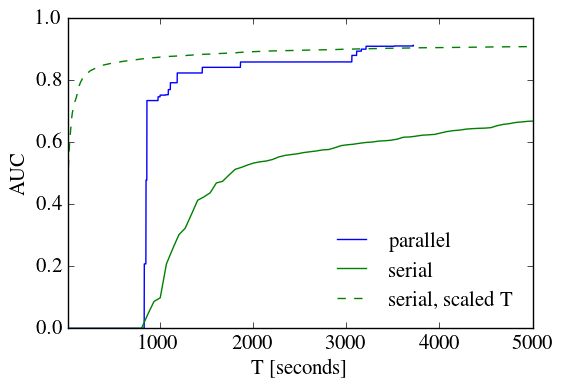

In [428]:
plt.plot(ttp,mmp,label="parallel")
# plt.plot(all_t,all_maxs)
plt.plot(tt,mm,label="serial")
plt.plot(tt/100,mm,"--g",label="serial, scaled T")
# plt.xlim([-50,5e3])
plt.xlim([10,5e3])
plt.ylabel('AUC',size=fontsize)
plt.xlabel('T [seconds]',size=fontsize)
plt.legend(frameon=False,loc="lower right",fontsize=fontsize)
plt.setp(plt.gca().get_yticklabels(),fontsize=fontsize)
plt.setp(plt.gca().get_xticklabels(),fontsize=fontsize)
plt.show()

## Mean time until best auc is found 

In [484]:
replicas = 100
#compute the mean value of the time necessary to find the best AUC value
ttmax = generate_maximum_times(ts,aucs,replicas)
#compute actual time it took in parallel
tmaxp = all_t[np.argmax(all_auc)]


In [497]:
#Mean speedup
print("Mean speedup: {}".format(np.mean(ttmax)/tmaxp))
print("Mean time serial: {} hours".format(np.mean(ttmax)/3600))
print("Time parallel: {} hours".format(tmaxp/3600))
#its a uniform distribution
# plt.close()
# plt.hist(ttmax)
# plt.show()
# # tt

Mean speedup: 88.2172247234
Mean time serial: 91.1707864167 hours
Time parallel: 1.03348055556 hours


In [513]:
def time_sensitive_interp(x,t,t_new):
    indices = np.maximum(0,np.searchsorted(t,t_new,side='right')-1)
    return x[indices]


def place_maxs_onto_grid(t,y,num=100,tt=None):
#     tt = np.unique(t)
    if tt is None:
        tt = np.linspace(0,np.max(t),num)
    return tt,time_sensitive_interp(y,t,tt)

def generate_mean_reach_times(ts,aucs,replicas = 10):
    tts = []
    mm = np.unique(np.concatenate(aucs))
    tts = np.zeros_like(mm)
    for i in range(replicas):
        all_t_serial,all_auc_serial,all_maxs_serial = generate_serial_auc_stats(ts,aucs)
        for (j,m) in enumerate(mm):
            tts[j] += all_t_serial[np.argmax(all_maxs_serial >= m)]
    tts /= replicas
    return tts,mm



def generate_maximum_times(ts,aucs,replicas = 10):
    tts = []
    for i in range(replicas):
        all_t_serial,all_auc_serial,all_maxs_serial = generate_serial_auc_stats(ts,aucs)
        ind = np.argmax(all_auc_serial)
        tts.append(all_t_serial[ind])
    return tts

def average_accum_curves(ts,aucs,replicas = 10,num = 1000):
    all_mm = 0
    tt = 0
    for i in range(replicas):
        all_t_serial,all_auc_serial,all_maxs_serial = generate_serial_auc_stats(ts,aucs)
        grid = np.unique(all_t_serial)
        tt,mm = place_maxs_onto_grid(all_t_serial,all_maxs_serial,num,grid)
        all_mm += mm
    all_mm /= replicas
    return tt,all_mm

def average_accum_curves_by_t(ts,aucs,replicas = 10,num = 1000):
    mm = 0
    all_tt = 0
    for i in range(replicas):
        all_t_serial,all_auc_serial,all_maxs_serial = generate_serial_auc_stats(ts,aucs)
        grid = np.unique(all_auc_serial)
        mm,tt = place_maxs_onto_grid(all_maxs_serial,all_t_serial,num,grid)
        all_tt += tt
    all_tt /= replicas
    return mm,all_tt

def generate_serial_times_aucs(ts,aucs):
    combined = list(zip(ts, aucs))
    shuffle(combined)
    ts,aucs = zip(*combined)
    ts_new = []
    for t in ts:
        if len(ts_new) == 0:
            ts_new.append(1.0*t)
        else:
            ts_new.append(1.0*t + ts_new[-1][-1])
    return ts_new,aucs

def get_raw_ts_aucs(filenames,patience=5):
    ts = []
    aucs = []
    auc_maxs = []
    for f in filenames:
        dataset = pd.read_csv(f)
        t = np.concatenate((np.array([0]),np.array(dataset['times'])))
        auc = np.concatenate((np.array([0]),np.array(dataset['val_roc'])))
        max_index = np.argmax(auc)
        auc = auc[:max_index+patience+1]
        t = t[:max_index+patience+1]
        auc_max = np.maximum.accumulate(auc) 
        ts.append(t)
        aucs.append(auc)
        auc_maxs.append(auc_max)
    return ts,aucs

def get_global_auc_stats(ts,aucs):
    all_t = np.concatenate(ts)
    all_aucs = np.concatenate(aucs)
    all_t,all_aucs = zip(*sorted(zip(all_t,all_aucs),key = lambda x : x[0]))
    all_t = np.array(all_t)
    all_aucs = np.array(all_aucs)
    all_auc_maxs = np.maximum.accumulate(all_aucs)  
    return all_t,all_aucs,all_auc_maxs

def generate_serial_auc_stats(ts,aucs):
    ts,aucs = generate_serial_times_aucs(ts,aucs)
    return get_global_auc_stats(ts,aucs)